In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [12]:
# function to load group of files, like body_acc_x_train.txt, body_acc_y_train.txt, etc.
def load_signal_group(group, data_path):
  signals = []
  prefix = f'{data_path}/{group}/Inertial Signals/'
  for signal_type in ['body_acc', 'body_gyro', 'total_acc']:
    for axis in ['x', 'y', 'z']:
      file_path = f'{prefix}{signal_type}_{axis}_{group}.txt'
      signal = pd.read_csv(file_path, delim_whitespace=True, header=None).values
      signals.append(signal)

  return np.stack(signals, axis=1)

In [13]:
# function to laod labels files, y_train.txt etc
def load_labels(group, data_path):
  file_path = f'{data_path}/{group}/y_{group}.txt'
  labels = pd.read_csv(file_path, header=None).values
  return labels - 1  # Subtract 1 to make labels 0-indexed (0-5 instead of 1-6)

In [14]:
# loading the dataset
data_path = '/content/drive/MyDrive/UCI HAR Dataset'

In [24]:
X_train_signals = load_signal_group('train', data_path)
y_train = load_labels('train', data_path)

X_test_signals = load_signal_group('test', data_path)
y_test = load_labels('test', data_path)

X_train_signals = np.transpose(X_train_signals, (0, 2, 1))
X_test_signals = np.transpose(X_test_signals, (0, 2, 1))

/tmp/ipython-input-3757178204.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(file_path, delim_whitespace=True, header=None).values
/tmp/ipython-input-3757178204.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(file_path, delim_whitespace=True, header=None).values
/tmp/ipython-input-3757178204.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(file_path, delim_whitespace=True, header=None).values
/tmp/ipython-input-3757178204.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(file_path, delim_whitespace=True, 

In [25]:
X_train_signals.shape

(7352, 128, 9)

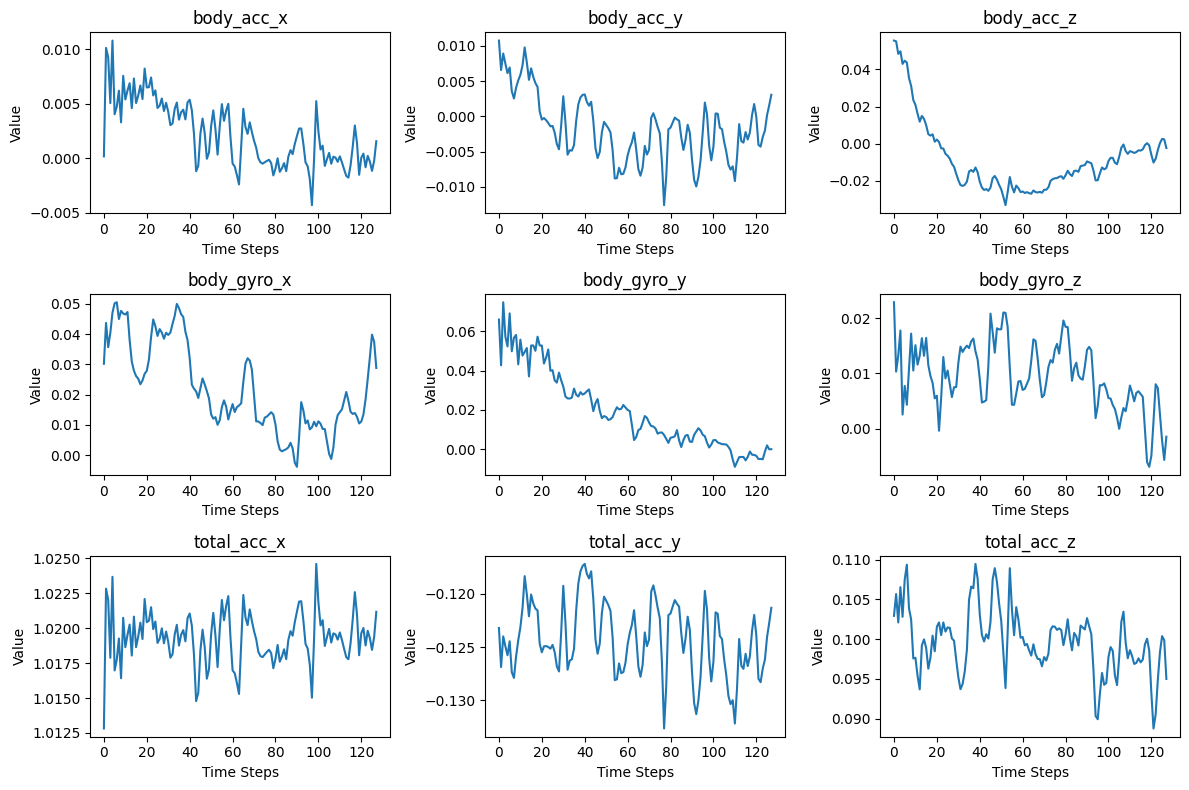

In [22]:
import matplotlib.pyplot as plt

sample = X_train_signals[0]  # (9, 128)
channels = ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(sample[i], label=channels[i])
    plt.title(channels[i])
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [26]:
# creating dataloaders

# coverting to pytorch tensors,  but we need shape to be (smples, channels, timestemps) for cnn
X_train = torch.from_numpy(X_train_signals).float().permute(0, 2, 1)
y_train = torch.from_numpy(y_train).float().long().squeeze()

X_test = torch.from_numpy(X_test_signals).float().permute(0, 2, 1)
y_test = torch.from_numpy(y_test).long().squeeze()

In [28]:
# creating dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# creating dataloader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# CNN and LSTM hybrid model define
class HARModel(nn.Module):
  def __init__(self, input_channels, num_classes):
    super(HARModel, self).__init__()

    # cnn feature extractor
    self.cnn_block = nn.Sequential(
        nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2)
      )

    # lstm sequence modeler
    # The input features to LSTM will be the output channels of the CNN
    self.lstm = nn.LSTM(input_size=64, hidden_size=100, num_layers=2,
                            batch_first=True, bidirectional=True)

    self.dropout = nn.Dropout(0.5)
    # The input to the classifier is twice the hidden size because the LSTM is bidirectional
    self.classifier = nn.Linear(100 * 2, num_classes)

  def forward(self, x):
    # x shape: (batch_size, input_channels, sequence_length) -> e.g., (64, 9, 128)

        x = self.cnn_block(x)
        # x shape after CNN: (batch_size, cnn_output_channels, new_sequence_length) -> e.g., (64, 64, 64)

        # We need to switch dimensions for LSTM: (batch_size, sequence_length, features)
        x = x.permute(0, 2, 1)

        x, (hidden, cell) = self.lstm(x)

        # We take the final hidden state of the LSTM from both directions
        # Concatenate the final forward and backward hidden states
        x = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        x = self.dropout(x)
        out = self.classifier(x)
        return out

# Instantiate the model
input_channels = 9
num_classes = 6 # (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HARModel(input_channels, num_classes).to(device)

In [30]:
# model training

# hyperparameter
learning_rate = 0.001
num_epochs = 20

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    for i, (signals, labels) in enumerate(train_loader):
        signals, labels = signals.to(device), labels.to(device)

        # Forward pass
        outputs = model(signals)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.6400
Epoch [2/20], Loss: 0.3757
Epoch [3/20], Loss: 0.4934
Epoch [4/20], Loss: 0.1865
Epoch [5/20], Loss: 0.1008
Epoch [6/20], Loss: 0.0749
Epoch [7/20], Loss: 0.1207
Epoch [8/20], Loss: 0.1669
Epoch [9/20], Loss: 0.1128
Epoch [10/20], Loss: 0.0647
Epoch [11/20], Loss: 0.1457
Epoch [12/20], Loss: 0.1118
Epoch [13/20], Loss: 0.1443
Epoch [14/20], Loss: 0.0643
Epoch [15/20], Loss: 0.0944
Epoch [16/20], Loss: 0.0595
Epoch [17/20], Loss: 0.0276
Epoch [18/20], Loss: 0.0450
Epoch [19/20], Loss: 0.0807
Epoch [20/20], Loss: 0.1162


In [32]:
model.eval()

HARModel(
  (cnn_block): Sequential(
    (0): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 100, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=200, out_features=6, bias=True)
)

In [33]:
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy on test data: {100 * correct / total:.2f} %')

Accuracy on test data: 92.53 %


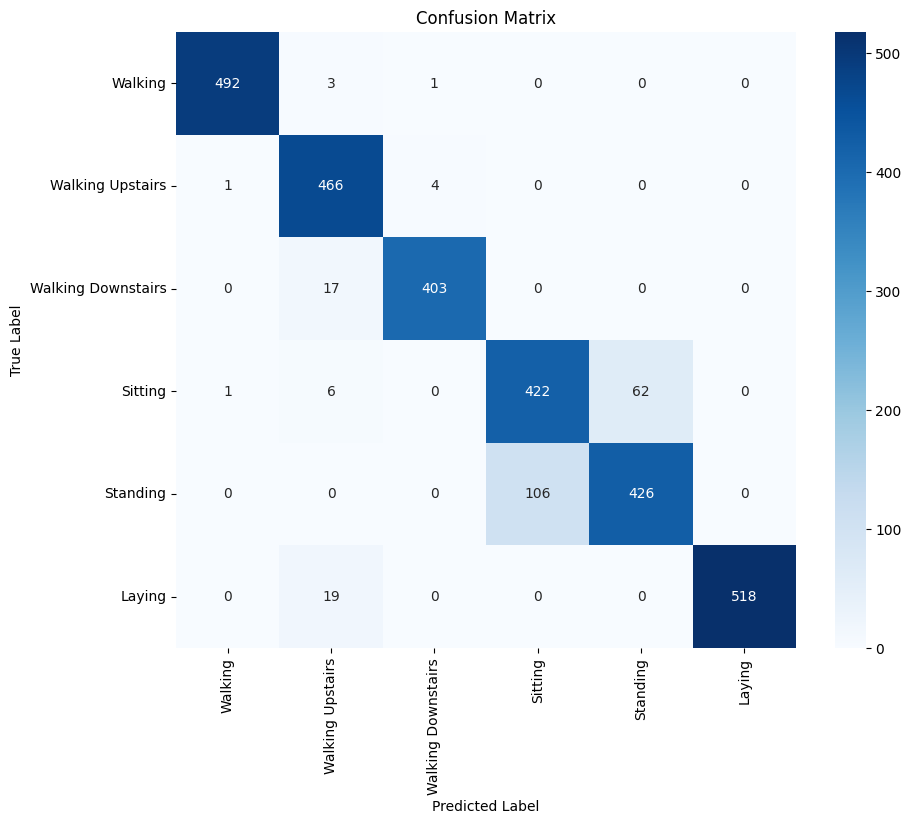

In [34]:
# Plotting the confusion matrix
activity_labels = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()